# TOXIC TWEET CLASSIFICATION

In [1]:
!pip install -q texthero

     |████████████████████████████████| 235 kB 52.0 MB/s 
     |████████████████████████████████| 1.5 MB 51.5 MB/s 
     |████████████████████████████████| 749 kB 65.9 MB/s 


In [2]:
! pip install -q scikit-multilearn

     |████████████████████████████████| 89 kB 5.2 MB/s 


In [3]:
! pip install -q transformers

     |████████████████████████████████| 4.2 MB 18.8 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 44.4 MB/s 
     |████████████████████████████████| 6.6 MB 61.1 MB/s 


In [4]:
!pip install -q tensorflow-text

     |████████████████████████████████| 4.6 MB 35.7 MB/s 
     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 5.8 MB 62.5 MB/s 
     |████████████████████████████████| 1.6 MB 16.0 MB/s 
     |████████████████████████████████| 438 kB 63.9 MB/s 


In [5]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.1 MB 15.0 MB/s 
     |████████████████████████████████| 1.2 MB 67.4 MB/s 
     |████████████████████████████████| 47.8 MB 107 kB/s 
     |████████████████████████████████| 1.1 MB 35.4 MB/s 
     |████████████████████████████████| 636 kB 69.9 MB/s 
     |████████████████████████████████| 92 kB 10.0 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 237 kB 62.2 MB/s 
     |████████████████████████████████| 99 kB 10.7 MB/s 
     |████████████████████████████████| 352 kB 56.2 MB/s 


Loading the dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Exploration

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
sns.set_style("whitegrid")
#sns.set(font_scale=1)

In [9]:
# Read data
df = pd.read_csv("/content/drive/MyDrive/ST Dataset/train.csv")

In [10]:
# check number of rows and columns 
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 159571
Number of columns: 8


In [11]:
# display few rows of the data
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


 - id : identifier of the comment
 - comment_text: text in the comment
 - toxic,severe_toxic, obscene, threat, insult, identity_hate: labels assigned to the comment

In [ ]:
# checking for any null values
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

We do not have any null values in the data.

### Length of the comments
We can first visualize the length of the comments. We will see a rough distribution of the comments lengths by couting the number of words used in the comments.

In [ ]:
comment_lengths = [len(comment.split()) for comment in df["comment_text"]]

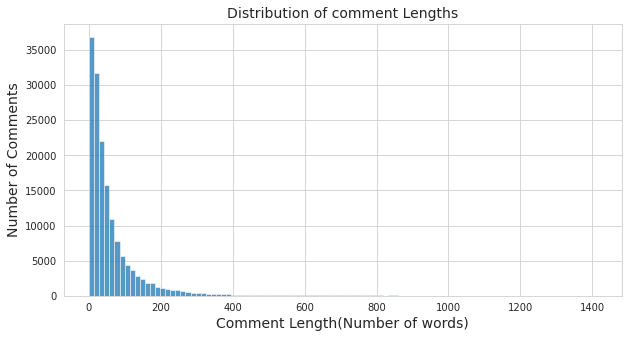

In [ ]:
# plot the distribution of tweet lengths
plt.figure(figsize=(10,5))
sns.histplot(comment_lengths, bins=100);
plt.xlabel("Comment Length(Number of words)", fontsize=14);
plt.ylabel("Number of Comments", fontsize=14);
plt.title("Distribution of comment Lengths", fontsize=14);

We can see that most of the comments have the tweet lengths around 200 words. Few comments have very high length. We can further see the distribution of the comment lengths by each labels.

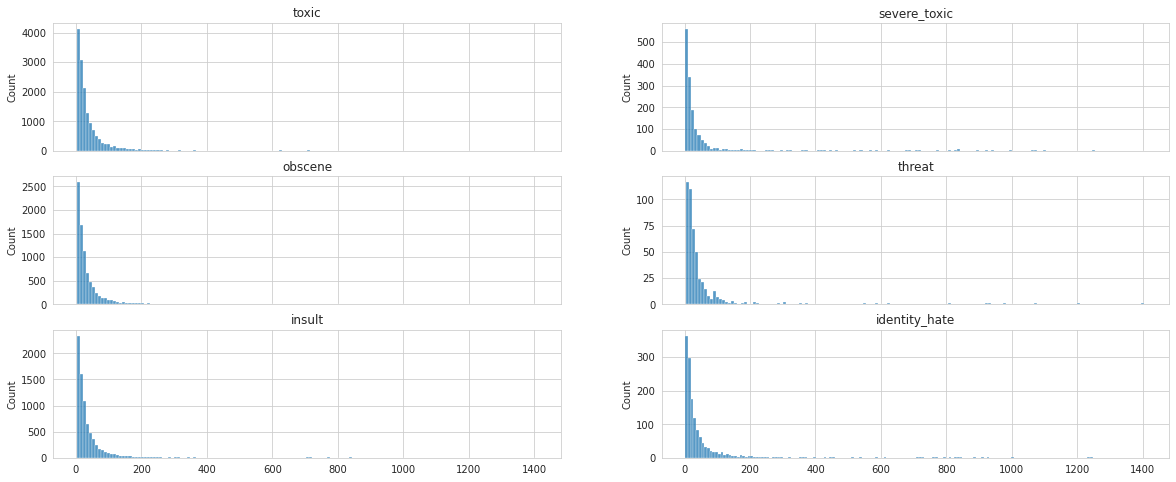

In [ ]:
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
fig, ax = plt.subplots(3, 2, figsize=(20,8), sharex=True)
axes =ax.ravel()
for i in range(6):
  comments = df.loc[df[labels[i]] == 1, :]
  comment_len = [len(comment.split()) for comment in comments["comment_text"]]
  sns.histplot(comment_len, ax=axes[i], bins = 150);
  axes[i].title.set_text(labels[i]);

#plt.tight_layout()
#plt.suptitle("Distribution of Comment lengths for the labels");


From the plots, we see that the distribution of the comment lengths for the labels are very similar. For label 'sever_toxic','threat' and 'identity_hate', it seems to have more comments with high comment lengths compared to others.

### Distribution of Labels

Since this is a multi label classification task, each comment can have more than one label. Here, we will see number of comments belonging to a label. Also, we will see if comments are not classified to any labels.

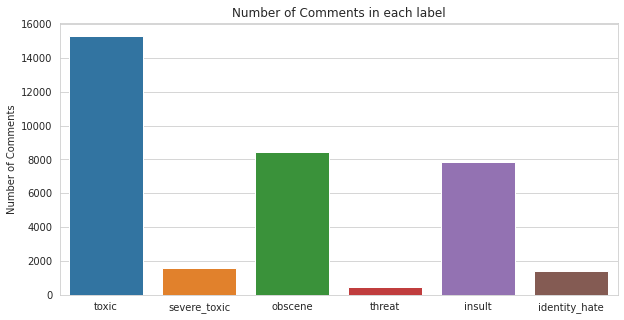

In [ ]:
# Number of tweets in each labels
labels_count = df[labels].sum()
plt.figure(figsize = (10,5))
sns.barplot(x = labels_count.index,y = labels_count.values);
plt.title("Number of Comments in each label");
plt.ylabel("Number of Comments");

As we see, there are higher number of comments belonging to toxic labels, and comments in sever_toxic, threat and identity_hate are low. So, here we have the problem of imbalanced data and therfore we will have to be careful in selecting the correct evaluation metric later.  

We can further check to see number of labels that a comment have.

In [ ]:
multilabel_count = df[labels].sum(axis = 1).value_counts()
multilabel_count

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

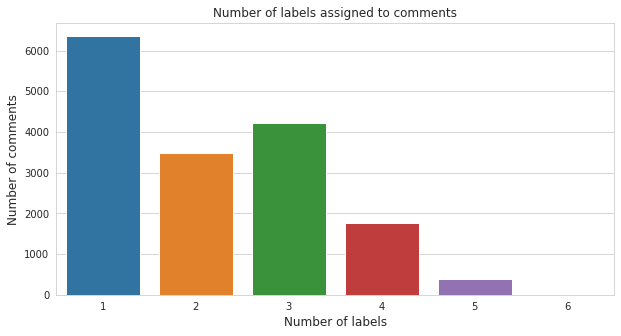

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x = multilabel_count.iloc[1:].index, y = multilabel_count.iloc[1:].values);
plt.title("Number of labels assigned to comments");
plt.xlabel("Number of labels", fontsize=12);
plt.ylabel("Number of comments",fontsize=12);

In [ ]:
# Number of tweets that does not have any labels
#no_labels = train[(train['toxic'] == 0) & (train['severe_toxic'] == 0) & (train['obscene'] == 0) & (train['threat'] == 0) & \
                  #(train['insult'] == 0) & (train['identity_hate'] == 0)]

print(f'Number of comments with no any labels(clean tweet): {multilabel_count.iloc[0]}')
print(f'Percentage of comments with no any labels: {round(multilabel_count.iloc[0]/len(df) * 100,3)}%')

Number of comments with no any labels(clean tweet): 143346
Percentage of comments with no any labels: 89.832%


There are very high number, about 90% of the comments that do not have any toxic labels assigned to them.

### Wordcloud 

Here we will use word cloud to visualize most frequent words used in the tweets.

In [12]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import re 
import texthero as hero
from texthero import preprocessing, wordcloud

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Before we display the word cloud, we will clean the text. We will use package **texthero**, which provides easy apis for text processing. The purpose of cleaning the text here is for not to show stopwords that would be meaningless.

In [13]:
# clean text for word cloud
# using tethero
wc_pipeline = [
               preprocessing.remove_urls, # remove urls
               preprocessing.remove_punctuation, # remove punctuation
               preprocessing.remove_digits, # remove numbers
               preprocessing.remove_diacritics,
               preprocessing.lowercase, # convert to lowercase
               preprocessing.remove_stopwords, # remove stopwords
               preprocessing.remove_whitespace # remove any extra spaces
               ]
 
# apply the procesing pipeline
wc_text = hero.clean(df['comment_text'], wc_pipeline)

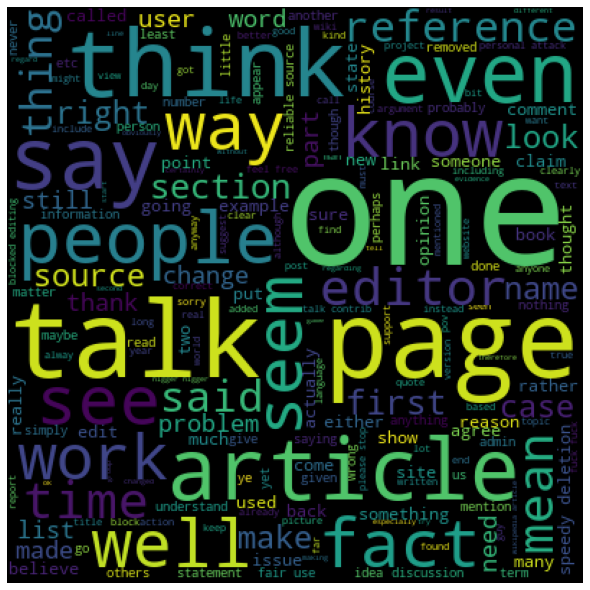

In [ ]:
word_cloud = WordCloud(stopwords=set(STOPWORDS),
                       width = 400, height=400,
                       min_font_size=4).generate(" ".join(wc_text.values))
                       
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Correlation between the target labels

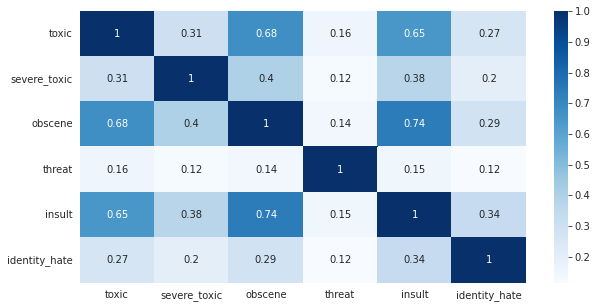

In [ ]:
labels_cor = df[labels].corr()
plt.figure(figsize=(10,5))
sns.heatmap(labels_cor, annot=True, cmap='Blues');

Label toxic have high correlation with obscene and insult. Similarly labels insult and obscene also have high correlation, which seems reasonable. 

### Data Partition

Before doing any modeling, we will partion the data into train and test splits.
We will train the model on train data and evaluate the results on test data.
 

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train, test = train_test_split(df, test_size = 0.3, random_state = 1)

In [16]:
# check the size of train and test data
print("Train:", train.shape)
print("Test:", test.shape)

Train: (111699, 8)
Test: (47872, 8)


## Modeling with Bag of Words

### Data Processing

We will now preprocess the text for modeling, here we will just extend our processing pipeling we created for wordcloud by adding stemming to the pipeline.

In [17]:
clean_text_pipeline = [
               preprocessing.remove_urls, # remove urls
               preprocessing.remove_punctuation, # remove punctuation
               preprocessing.remove_digits, # remove numbers
               preprocessing.remove_diacritics,
               preprocessing.lowercase, # convert to lowercase
               preprocessing.remove_stopwords, # remove stopwords
               preprocessing.remove_whitespace , # remove any extra spaces
               preprocessing.stem # stemming of the words
               ]

In [18]:
# applying the processing pipeline
train['clean_text'] = hero.clean(train['comment_text'], clean_text_pipeline)
test['clean_text'] = hero.clean(test['comment_text'], clean_text_pipeline)

In [ ]:
# comparison of text before and after the processing
print("Original Text:")
print(train['comment_text'].iloc[0], '\n')
print("Clean Text:")
print(train['clean_text'].iloc[0])

print("------------------------------------")

print("Original Text:")
print(train['comment_text'].iloc[1], '\n')
print("Clean Text:")
print(train['clean_text'].iloc[1])


Original Text:
"

 Happy Birthday! 

Hey,  .  Just stopping by to wish you a Happy Birthday from the Wikipedia Birthday Committee!   Have a great day!    " 

Clean Text:
happi birthday hey stop wish happi birthday wikipedia birthday committe great day
------------------------------------
Original Text:
I have no problem with the Homosexual organisations proposal, but it being a sub-category of LGBT seems contradictive. Those who optioned no on NAMBLA's inclusion under LGBT category argue that the conception of gay is restricted to adult men. Following that, all homosexual males would not be gay because obviously those underaged had not qualifyed to be gay. Thus, a sub-category would contain something that is not part of the super-category. 

Clean Text:
problem homosexu organis propos sub categori lgbt seem contradict option nambla inclus lgbt categori argu concept gay restrict adult men follow homosexu male would gay obvious underag qualifi gay thus sub categori would contain someth p

### Vectorization - Bag Of Words

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
# separate features and labels
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

x_train = train.loc[:,'clean_text']
y_train = train[labels]

x_test = test.loc[:,'clean_text']
y_test = test[labels]

In [21]:
# tfdif vectorizer with 1 and 2 ngrams
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), 
                            min_df=2, 
                            max_features=1000)
tfidf_vec.fit(x_train)

TfidfVectorizer(max_features=1000, min_df=2, ngram_range=(1, 2))

In [22]:
# trasform train and test
train_tfidf = tfidf_vec.transform(x_train)
test_tfidf = tfidf_vec.transform(x_test)

In [23]:
train_tfidf

<111699x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2005417 stored elements in Compressed Sparse Row format>

In [24]:
# extracted features
print(tfidf_vec.get_feature_names())

['abl', 'absolut', 'abus', 'academ', 'accept', 'access', 'accord', 'account', 'accur', 'accus', 'across', 'act', 'action', 'activ', 'actual', 'ad', 'add', 'addit', 'address', 'admin', 'administr', 'admit', 'advertis', 'advic', 'afd', 'age', 'ago', 'agre', 'aid', 'air', 'album', 'align', 'alleg', 'allow', 'almost', 'alon', 'along', 'alreadi', 'also', 'altern', 'although', 'alway', 'america', 'american', 'among', 'amount', 'anim', 'anonym', 'anoth', 'answer', 'anti', 'anyon', 'anyth', 'anyway', 'apolog', 'appar', 'appear', 'appli', 'appreci', 'appropri', 'april', 'arab', 'archiv', 'area', 'argu', 'argument', 'around', 'art', 'articl', 'articl delet', 'articl talk', 'articl would', 'ask', 'ask question', 'ass', 'ass ass', 'assert', 'asshol', 'associ', 'assum', 'attack', 'attempt', 'attent', 'august', 'author', 'automat', 'avail', 'avoid', 'awar', 'award', 'away', 'back', 'background', 'background color', 'bad', 'ball', 'ball ball', 'ban', 'band', 'bark', 'barnstar', 'base', 'basic', 'batt

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
len(tfidf_vec.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1000

### Binary Relevance

In [ ]:
#from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, log_loss, hamming_loss, accuracy_score

In [ ]:
# evaluation function
def eval_fun_br(x_test, y_test, classifier):
    # make label predictions
    y_labels = classifier.predict(x_test).todense()
    # make probabilities predictions
    y_pred = classifier.predict_proba(x_test).todense()

    # accuracy score as the average of accuracy for individual labels
    accuracy = np.mean([accuracy_score(y_test.iloc[:,i], y_labels[:,i]) for i in range (6)])

    # hamming loss
    #ham_loss = hamming_loss(y_test, y_labels)

    # auc as the average of auc for individual labels
    auc = np.mean([roc_auc_score(y_test.iloc[:,i], y_pred[:,i]) for i in range (6)])

    # logloss as the average of logloss for individual labels
    logloss = np.mean([log_loss(y_test.iloc[:,i], y_pred[:,i]) for i in range(6)])

    return pd.DataFrame({'Model':'BR-' + type(classifier.classifier).__name__,
                        "Accuracy": np.round(accuracy,3),
                        #"Hamming Loss": np.round(ham_loss,3),
                        "AUC": np.round(auc,3) ,
                        "Log loss": np.round(logloss,3)}, index = [0])

**Logistic Regression**

In [ ]:
# Logistic Regression
lr_clf = BinaryRelevance(LogisticRegression( solver='liblinear'))
lr_clf.fit(train_tfidf, y_train)

BinaryRelevance(classifier=LogisticRegression(solver='liblinear'),
                require_dense=[True, True])

In [ ]:
# evaluation
lr_eval = eval_fun_br(x_test=test_tfidf, y_test=y_test, classifier=lr_clf)
lr_eval

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

,Model,Accuracy,AUC,Log loss
0,BR-LogisticRegression,0.979,0.96,0.064


**Naive Bayes**

In [ ]:
nb_clf = BinaryRelevance(MultinomialNB())
nb_clf.fit(train_tfidf, y_train)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
# evaluation
nb_eval = eval_fun_br(x_test=test_tfidf, y_test=y_test, classifier=nb_clf)
nb_eval

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

,Model,Accuracy,AUC,Log loss
0,BR-MultinomialNB,0.976,0.955,0.071


In [ ]:
# comparison of Binary Relevance Results
BR_results = lr_eval.append(nb_eval).reset_index(drop = True)
BR_results

,Model,Accuracy,AUC,Log loss
0,BR-LogisticRegression,0.979,0.960,0.064
1,BR-MultinomialNB,0.976,0.955,0.071


### Classifier Chain 

In [ ]:
from sklearn.multioutput import ClassifierChain

In [ ]:
# evaluation function
def eval_fun_chain(x_test, y_test, classifier):
    # make label predictions
    y_labels = classifier.predict(x_test)
    # make probabilities predictions
    y_pred = classifier.predict_proba(x_test)

    # accuracy score as the average of accuracy for individual labels
    accuracy = np.mean([accuracy_score(y_test.iloc[:,i], y_labels[:,i]) for i in range (6)])

    # hamming loss
    #ham_loss = hamming_loss(y_test, y_labels)

    # auc as the average of auc for individual labels
    auc = np.mean([roc_auc_score(y_test.iloc[:,i], y_pred[:,i]) for i in range (6)])

    # logloss
    logloss = np.mean([log_loss(y_test.iloc[:,i], y_pred[:,i]) for i in range(6)])

    return pd.DataFrame({'Model':'Chain-' + type(classifier.base_estimator).__name__,
                        "Accuracy": np.round(accuracy,3),
                        #"Hamming Loss": np.round(ham_loss,3),
                        "AUC": np.round(auc,3) ,
                        "Log loss": np.round(logloss,3)}, index = [0])

**Logistic Regression**

In [ ]:
lr_chain = ClassifierChain(LogisticRegression(solver='liblinear'))
lr_chain.fit(train_tfidf, y_train)

ClassifierChain(base_estimator=LogisticRegression(solver='liblinear'))

In [ ]:
lr_chain_eval = eval_fun_chain(test_tfidf, y_test, lr_chain)
lr_chain_eval

,Model,Accuracy,AUC,Log loss
0,Chain-LogisticRegression,0.979,0.95,0.069


**Naive Bayes**

In [ ]:
nb_chain = ClassifierChain(MultinomialNB())
nb_chain.fit(train_tfidf, y_train)

ClassifierChain(base_estimator=MultinomialNB())

In [ ]:
nb_chain_eval = eval_fun_chain(test_tfidf, y_test, nb_chain)
nb_chain_eval

,Model,Accuracy,AUC,Log loss
0,Chain-MultinomialNB,0.968,0.946,0.124


In [ ]:
# comparison of the models
chain_results = lr_chain_eval.append(nb_chain_eval).reset_index(drop = True)
chain_results

,Model,Accuracy,AUC,Log loss
0,Chain-LogisticRegression,0.979,0.950,0.069
1,Chain-MultinomialNB,0.968,0.946,0.124


Again we see that using chain classifier, logistic regression is performing better than naive bayes.

**Comparing Binary Relevance and Chain Classifier**

In [ ]:
# Comparing Binary Relevance and Chain Classifier
br_chain_results = BR_results.append(chain_results).reset_index(drop = True)
br_chain_results

,Model,Accuracy,AUC,Log loss
0,BR-LogisticRegression,0.979,0.960,0.064
1,BR-MultinomialNB,0.976,0.955,0.071
2,Chain-LogisticRegression,0.979,0.950,0.069
3,Chain-MultinomialNB,0.968,0.946,0.124


From the results, we see Logistic Regression with Binary Relevance is performing the best. Chain Classifier works better when there is dependencies between the multilabels. But, from our correlation plot above between the labels, we saw ther was no any significant correlation. Thus, here chain classifier is not performing better than the binary relevance.  

We can further tune the best performing Binary Relevance Logistic model to see if we can get aby further improvement. For the hyperparameter tuning, we will be tunig the cost parameter 'C', that specifies the regularization strength.

### Hyperparameter Tuning 

For Binary Relevance Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = [{'classifier':[LogisticRegression(solver='liblinear')],
               'classifier__C':[0.0001, 0.05, 1, 10,100,1000]}]
lr_search = GridSearchCV(BinaryRelevance(), param_grid=parameters, scoring='accuracy', cv = 4)
lr_search.fit(train_tfidf, y_train)

GridSearchCV(cv=4, estimator=BinaryRelevance(require_dense=[True, True]),
             param_grid=[{'classifier': [LogisticRegression(C=1,
                                                            solver='liblinear')],
                          'classifier__C': [0.0001, 0.05, 1, 10, 100, 1000]}],
             scoring='accuracy')

In [ ]:
# print the best parameter
lr_search.best_params_

{'classifier': LogisticRegression(C=1, solver='liblinear'), 'classifier__C': 1}

The best value for the parameter 'C' was 1 from the hyperparameter tuning, which is the default parameter. So, here our original Logistic Regression model with default parameter is performing the best. Therefore, we would not have to update our model.

### Word Embeddings/ Sentence Embeddings


We saw that Binary Relevance with Logistic Regression is performing the best. We applied bag of words to represent the text into vector forms. Word embeddings are getting popular as they can also maintian the word order in the text. There are many ways of getting word embeddings and we can train our own also. But, here we will make use of already trained word2vec model from Google to extract the embeddings.

Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence. 

The code for creating word embeddnigs is taken from [here](https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb)

In [ ]:
!pip install -q gensim

In [ ]:
import gensim
import gensim.downloader as api

In [ ]:
# download googles pretrained word2vec model
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
#load the vectors from the model
word_vectors = model.wv 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
type(word_vectors)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [ ]:
# getting average of word vectors for every word in the text

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing=False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, 
                                                            generate_missing=generate_missing))
    return list(embeddings)

Before creating the word embeddings, we will create a different text processing function than we used for bag of words.  We will remove the step for stemming.

In [ ]:
clean_we_pipeline = [
               preprocessing.remove_urls, # remove urls
               preprocessing.remove_punctuation, # remove punctuation
               preprocessing.remove_digits, # remove numbers
               preprocessing.remove_diacritics,
               preprocessing.lowercase, # convert to lowercase
               preprocessing.remove_stopwords,
               preprocessing.remove_whitespace  # remove any extra spaces  
               ]

In [ ]:
train_we_text = hero.clean(train['comment_text'], clean_we_pipeline)
test_we_text = hero.clean(test['comment_text'], clean_we_pipeline)

In [ ]:
# tokenizing the texts into words
train_we_tokens = train_we_text.apply(lambda x: x.split())
test_we_tokens = test_we_text.apply(lambda x: x.split())

In [ ]:
# generate train and test embeddings
train_embeddings = get_word2vec_embeddings(vectors=word_vectors, tokens=train_we_tokens)
test_embeddings = get_word2vec_embeddings(vectors=word_vectors, tokens=test_we_tokens)

In [ ]:
print(type(train_embeddings))
print(len(train_embeddings))

<class 'list'>
111699


At the moment we have train and test embeddings as a list of 300 size vector array for each sentence in our data. We will convert them to a matrix format, where each sentence will be represented by a array of 300 dimension.

In [ ]:
train_embeddings_matrix = np.array(train_embeddings)
test_embeddings_matrix = np.array(test_embeddings)

print(train_embeddings_matrix.shape,  test_embeddings_matrix.shape)

(111699, 300) (47872, 300)


We can try to visualize how good the embeddings can dinstinguish the sentences into the labels. Since, here we have multi labels for each sentences, it will be difficult to visualize all the labels for a single sentence in a single plot. So we will reduce the labels to only two, either any presence of the toxic label or no any toxic labels. We will visualize then with the help of PCA.

In [ ]:
# make labels to indicate either presence of a toxic label or not
labels_present = (y_train.sum(axis = 1) > 1).astype('int')

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD

In [ ]:
pca_component = TruncatedSVD(n_components=2).fit_transform(train_embeddings_matrix)

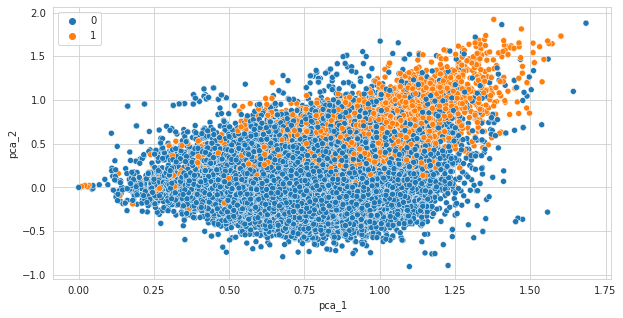

In [ ]:
# visuslize
plt.figure(figsize=(10,5))
sns.scatterplot(x = pca_component[:,0], y = pca_component[:,1], hue=labels_present);
plt.xlabel('pca_1');
plt.ylabel('pca_2');

We see that by representing with only 2 pca components se can see some separation of the texts, but still there are overlaps.

We will now use the embeddings to create the classification model. Since, Binary Relevance with Logistic Regression has been the best so far, we will use it to train with the embeddings and see if we can get better results.

**Binary Relevance -Logistic Regreesion with word embeddings**

In [ ]:
lr_we = BinaryRelevance(LogisticRegression(solver = 'liblinear'))
lr_we.fit(train_embeddings_matrix, y_train)

BinaryRelevance(classifier=LogisticRegression(solver='liblinear'),
                require_dense=[True, True])

In [ ]:
# evaluation
lr_we_results = eval_fun_br(x_test=test_embeddings_matrix, y_test=y_test, classifier=lr_we)
lr_we_results

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

,Model,Accuracy,AUC,Log loss
0,BR-LogisticRegression,0.975,0.965,0.071


Here the resuls show that the embeddings did not perform any better than the bag of words method. The results are almost the same, we can still consider Binary Relevance with Logistic Regression as the best method, considering its simplicity.

To improve our results we can try modeling with Deep Learning, using frameworks line CNN and LSTM. 


## DEEP LEARNING

**LSTM**

### Transfer Learning with Bert

There are many advanced models for NLP taks already trained on large corpus of data, and with the help of transfer learning we can leverage the results from them. BERT is one of the most popular such pretrained model and we will use it for our purpose.

Tensorflow HUB provides the list of many pretrained models and also has a very easy to use apis to use them. So, here we will use it to train our bert model with transfer learning for our task.

In [37]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

In [38]:
# before feeding the data to the model, we will clean it a bit
clean_text_bert_pipeline = [
               preprocessing.remove_urls, # remove urls
               preprocessing.remove_diacritics,
               preprocessing.remove_whitespace  # remove any extra spaces
               ]
train_bert = hero.clean(train['comment_text'], clean_text_bert_pipeline)
test_bert = hero.clean(test['comment_text'], clean_text_bert_pipeline)

In [39]:
# create targets
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train[labels]
y_test = test[labels]

In [40]:
y_train

,toxic,severe_toxic,obscene,threat,insult,identity_hate
39130,0,0,0,0,0,0
25049,0,0,0,0,0,0
437,1,0,1,0,1,0
93449,0,0,0,0,0,0
35166,0,0,0,0,0,0
...,...,...,...,...,...,...
73349,0,0,0,0,0,0
109259,0,0,0,0,0,0
50057,0,0,0,0,0,0
5192,0,0,0,0,0,0


In [41]:
# creating tensorflow dataset
# Preparaing the data to feed into the model
batch_size = 32
seed = 42

train_ds = tf.data.Dataset.from_tensor_slices((train_bert.values, y_train.values)).shuffle(50000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_bert.values, y_test.values)).shuffle(50000).batch(batch_size)

In [42]:
for train_batch in train_ds.take(1):
  print(train_batch[:2])

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'" Makah, Quileute, Chinook/Chinookan I don\'t have time right now to add bits on the Makah, into the Nuu-cha-nulth section as a subsubsection, the Quileute (who have absorbed the surviving Chemakuans from what is now Clallam/Twana turf); the Chinooks are usually held to be the southern ""pole"" of the Northwest Coast cultures; not sure why the Tillamooks aren\'t.....but the Chinook should probably be on here.... PS I made a redirect Northwest Coast culture which directs here....guess I\'ll do the same for Northwest Coast cultures (plural). "',
       b"I think that's what I meant, sorry. ()",
       b'(I think that might be better?)',
       b'" Inclusion criteria If inclusion criteria are going to be selective (or elitist), then I think it is necessary to define them for each sport. I would also say it is necessary to state why each individual meets those criteria. For example, what have golfers David Merkow and Rob Oppenheim don

**Loading the models form tensorflow hub**

In [ ]:
# tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
# tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [43]:
# create keras model 
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(500, activation='relu')(net)
  net = tf.keras.layers.Dense(6, activation= "sigmoid" , name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [44]:
classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

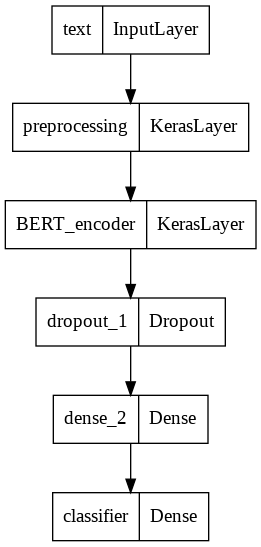

In [46]:
tf.keras.utils.plot_model(classifier_model,show_layer_names=True)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy(), tf.metrics.AUC(multi_label=True)]

In [ ]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compile the model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('best_bert_model', save_best_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

In [ ]:
# train the model
bert_history = classifier_model.fit(train_ds, 
                               validation_data=test_ds, 
                               epochs = epochs, 
                               callbacks = callbacks)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3491/3491 [==============================] - ETA: 0s - loss: 0.0730 - binary_accuracy: 0.9707 - auc: 0.9422

INFO:tensorflow:Assets written to: best_bert_model/assets


INFO:tensorflow:Assets written to: best_bert_model/assets


3491/3491 [==============================] - 625s 177ms/step - loss: 0.0730 - binary_accuracy: 0.9707 - auc: 0.9422 - val_loss: 0.0436 - val_binary_accuracy: 0.9829 - val_auc: 0.9780
Epoch 2/2
3491/3491 [==============================] - ETA: 0s - loss: 0.0389 - binary_accuracy: 0.9849 - auc: 0.9810

INFO:tensorflow:Assets written to: best_bert_model/assets


INFO:tensorflow:Assets written to: best_bert_model/assets


3491/3491 [==============================] - 614s 176ms/step - loss: 0.0389 - binary_accuracy: 0.9849 - auc: 0.9810 - val_loss: 0.0417 - val_binary_accuracy: 0.9836 - val_auc: 0.9774


In [ ]:
bert_history

From the performance curve, we see that after 3 epochs, both loss and auc score for validation data does not improve, while for train data it still improves,showing overfitting problem. We had set the callback to stop the training to prevent overfitting and also save the model at the best iteration.

In [ ]:
# load the best model
bert_model = tf.keras.models.load_model('best_bert_model', compile = False)

In [ ]:
# compile the model
bert_model.compile(optimizer=optimizer, loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)

In [ ]:
loss, accuracy,auc = bert_model.evaluate(test_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1496/1496 [==============================] - 126s 84ms/step - loss: 0.0417 - binary_accuracy: 0.9836 - auc: 0.9774


In [ ]:
print(f"Accuracy: {np.round(accuracy,4)}")
print(f"AUC: {np.round(auc,4)}")
print(f"Logloss: {np.round(loss,4)}")

Accuracy: 0.9836
AUC: 0.9774
Logloss: 0.0417


With transfer learning using BERT model, we see we achieve better results , with improvements in Accuracy, AUC and LogLoss.

**Loading the test data for prediction**

In [ ]:
sub_test = pd.read_csv('/content/drive/MyDrive/ST Dataset/test.csv')
sub_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


**Making Predictions**

Prediction with Binary Relevance Logistic Regression model

In [ ]:
# cleaning text and vectorizing
sub_test['clean_text'] = hero.clean(sub_test['comment_text'],clean_text_pipeline)
sub_test_vect = tfidf_vec.transform(sub_test['clean_text'])

In [ ]:
# prediction with Binary Relevance Logistic Regression model
pred_lr = lr_clf.predict_proba(sub_test_vect)

In [ ]:
pred_lr.todense().shape

(153164, 6)

In [ ]:
# function to save submission file
labels =['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
def create_submission_file(test_id, predictions, labels, filename):
  pred_df = pd.DataFrame(predictions, columns=labels)
  final_sub =pd.concat([test_id,sub_test,pred_df], axis = 1)
  final_sub.to_csv(filename, index=False)
  print("Output Created")

In [ ]:
# create submission file for logistic regression
create_submission_file(test_id=sub_test['id'], predictions=pred_lr.toarray(), labels=labels,
                       filename = "logistic_regression_results.csv")

Output Created


Prediction with BERT model

In [ ]:
# clean text for bert
bert_test = hero.clean(sub_test['comment_text'], clean_text_bert_pipeline)

In [ ]:
# make prediction
pred_test = bert_model.predict(bert_test)

4787/4787 [==============================] - 380s 79ms/step


In [ ]:
pred_test

array([[9.9780029e-01, 4.2762130e-01, 9.9166369e-01, 9.2579037e-02,
        9.7032601e-01, 4.2353496e-01],
       [1.5961456e-04, 1.0115539e-05, 6.9460417e-05, 1.9681091e-05,
        7.4134892e-05, 2.0088693e-05],
       [1.2696674e-04, 2.7601705e-05, 1.3274643e-04, 3.2817923e-05,
        9.2768758e-05, 4.5850487e-05],
       ...,
       [7.9244594e-05, 1.2736565e-05, 6.4391657e-05, 1.8918434e-05,
        4.9798233e-05, 3.8392751e-05],
       [8.6164822e-05, 1.3317128e-05, 4.6047498e-05, 2.4290161e-05,
        6.1262224e-05, 7.3808013e-05],
       [9.4582415e-01, 2.8422517e-03, 6.5764189e-01, 9.3773624e-04,
        1.5463397e-01, 5.9202313e-04]], dtype=float32)

In [ ]:
# create submission file
create_submission_file(test_id=sub_test['id'], labels = labels, predictions=pred_test,
                       filename = "bert_results.csv")

Output Created
